In [1]:
!pip install SimpleITK nibabel pydicom monai[all] transformers -q
!pip install 'protobuf==3.20.*' -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.5/28.5 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9

In [2]:
# Cell 2: Import libraries

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pydicom
import pandas as pd
import numpy as np
import pickle
from tqdm.auto import tqdm
import warnings
import logging
import glob
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, 
    recall_score, f1_score, roc_curve, precision_recall_curve,
    confusion_matrix
)
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns

from monai.transforms import (
    Spacing, Resize, Compose as MonaiCompose
)

warnings.filterwarnings('ignore')
logging.getLogger('pydicom').setLevel(logging.ERROR)

print("✓ All imports successful!")

<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-12-16 07:49:57.027897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765871397.336492      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765871397.386769      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✓ All imports successful!


In [3]:
# Cell 3: Configuration
class Config:
    # Paths
    BASE_PATH = '/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection'
    TRAIN_DIR = os.path.join(BASE_PATH, 'stage_2_train')
    METADATA_PATH = '/kaggle/input/study-metadata/study_metadata.pkl'
    
    # Model checkpoints base paths
    CHECKPOINT_PATHS = {
        'v2': '/kaggle/input/3dino-vit-v2/pytorch/default/1',
        'v3_session1': '/kaggle/input/3dino-vit-v3/pytorch/default/1',
        'v3_session2': '/kaggle/input/3dino-vit-v3/pytorch/default/2', 
        'v3_session3': '/kaggle/input/3dino-vit-v3/pytorch/default/3', 
        'v4': '/kaggle/input/3-dino-vit-v4/pytorch/default/1'# Best overall
    }
    
    # Model architecture (MUST match training config)
    INPUT_SIZE = (96, 96, 96)
    IN_CHANNELS = 1
    NUM_CLASSES = 1
    PATCH_SIZE = (16, 16, 16)
    EMBED_DIM = 1024  # ViT-Large Width
    DEPTH = 4
    NUM_HEADS = 16
    
    # Evaluation
    BATCH_SIZE = 8  # Larger for inference
    NUM_WORKERS = 6
    
    # Output
    OUTPUT_DIR = '/kaggle/working'
    MODEL_NAME = '3dino_vit_ich'
    
    # Device
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    SEED = 42

In [4]:
cfg = Config()
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

print("Configuration:")
print(f"  Model: 3DiNo-ViT (Depth={cfg.DEPTH}, Embed={cfg.EMBED_DIM})")
print(f"  Device: {cfg.DEVICE}")
print(f"  Checkpoint versions: {list(cfg.CHECKPOINT_PATHS.keys())}")

Configuration:
  Model: 3DiNo-ViT (Depth=4, Embed=1024)
  Device: cuda
  Checkpoint versions: ['v2', 'v3_session1', 'v3_session2', 'v3_session3', 'v4']


In [5]:
# Cell 4: Set seed
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(cfg.SEED)
print(f"✓ Random seed set to {cfg.SEED}")

✓ Random seed set to 42


In [6]:
# Cell 5: Load metadata and create splits
print("\nLoading metadata...")
with open(cfg.METADATA_PATH, 'rb') as f:
    metadata = pickle.load(f)

study_to_slices = metadata['study_to_slices']
train_df = metadata['train_df']

print(f"✓ Loaded metadata for {len(study_to_slices)} studies")

# Create studies list
studies = []
for study_id, slices in study_to_slices.items():
    if not slices: continue
    max_label = max([s['label'] for s in slices])
    studies.append({
        'study_id': study_id, 
        'label': max_label, 
        'num_slices': len(slices)
    })

studies_df = pd.DataFrame(studies)

# Split (same as training)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=cfg.SEED)
train_idx, temp_idx = next(splitter.split(studies_df, studies_df['label']))
temp_df = studies_df.iloc[temp_idx].reset_index(drop=True)

val_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=cfg.SEED)
val_idx, test_idx = next(val_splitter.split(temp_df, temp_df['label']))

train_studies = studies_df.iloc[train_idx].reset_index(drop=True)
val_studies = temp_df.iloc[val_idx].reset_index(drop=True)
test_studies = temp_df.iloc[test_idx].reset_index(drop=True)

print(f"\n✓ Data split:")
print(f"  Train: {len(train_studies)} studies ({train_studies['label'].mean():.2%} pos)")
print(f"  Val:   {len(val_studies)} studies ({val_studies['label'].mean():.2%} pos)")
print(f"  Test:  {len(test_studies)} studies ({test_studies['label'].mean():.2%} pos)")



Loading metadata...
✓ Loaded metadata for 21744 studies

✓ Data split:
  Train: 15220 studies (40.85% pos)
  Val:   3262 studies (40.86% pos)
  Test:  3262 studies (40.83% pos)


In [7]:
# Cell 6: Dataset class (same as training)
class ICH3DDataset(torch.utils.data.Dataset):
    def __init__(self, studies_df, study_to_slices, train_dir, transforms=None):
        self.studies = studies_df.to_dict('records')
        self.study_to_slices = study_to_slices
        self.train_dir = train_dir
        self.transforms = transforms
    
    def __len__(self):
        return len(self.studies)
    
    def _load_volume(self, study_id):
        slices = self.study_to_slices[study_id]
        slices.sort(key=lambda x: x['z_pos'])
        
        volume = []
        for s in slices:
            try:
                dcm = pydicom.dcmread(os.path.join(self.train_dir, f"{s['slice_id']}.dcm"))
                img = dcm.pixel_array.astype(np.float32)
                
                slope = float(dcm.RescaleSlope) if hasattr(dcm, 'RescaleSlope') else 1.0
                intercept = float(dcm.RescaleIntercept) if hasattr(dcm, 'RescaleIntercept') else 0.0
                img = img * slope + intercept
                
                img = np.clip(img, -1000, 400)
                img = (img + 1000) / 1400
                volume.append(img)
            except:
                continue
        
        if not volume:
            volume = [np.zeros((512, 512))]
        
        volume = np.stack(volume, axis=0)
        return volume
    
    def __getitem__(self, idx):
        study_info = self.studies[idx]
        study_id = study_info['study_id']
        label = torch.tensor(study_info['label'], dtype=torch.float32)
        
        volume = self._load_volume(study_id)
        volume = np.expand_dims(volume, axis=0)
        volume = torch.from_numpy(volume).float()
        
        if self.transforms:
            volume = self.transforms(volume)
        
        return {'image': volume, 'label': label}

In [8]:
# Cell 7: Create dataloaders
transforms = MonaiCompose([
    Spacing(pixdim=(1.0, 1.0, 1.0), mode='trilinear'),
    Resize(spatial_size=cfg.INPUT_SIZE, mode='trilinear')
])

print("\nCreating datasets...")
train_dataset = ICH3DDataset(train_studies, study_to_slices, cfg.TRAIN_DIR, transforms)
val_dataset = ICH3DDataset(val_studies, study_to_slices, cfg.TRAIN_DIR, transforms)
test_dataset = ICH3DDataset(test_studies, study_to_slices, cfg.TRAIN_DIR, transforms)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False, 
    num_workers=cfg.NUM_WORKERS, pin_memory=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False,
    num_workers=cfg.NUM_WORKERS, pin_memory=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False,
    num_workers=cfg.NUM_WORKERS, pin_memory=True
)

print(f"✓ Dataloaders created")


Creating datasets...
✓ Dataloaders created


In [9]:
# Cell 8: Define 3DiNo ViT model (EXACT copy from training)
class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim), nn.GELU(), nn.Linear(hidden_dim, dim)
        )
    
    def forward(self, x):
        attn_out, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))
        x = x + attn_out
        x = x + self.mlp(self.norm2(x))
        return x

class ThreeDINOClassifier(nn.Module):
    def __init__(self, 
                 img_size=None,
                 patch_size=None,
                 in_chans=None,
                 num_classes=None,
                 embed_dim=None,
                 depth=None,
                 num_heads=None):
        super().__init__()
        
        # Use config defaults
        img_size = img_size or cfg.INPUT_SIZE
        patch_size = patch_size or cfg.PATCH_SIZE
        in_chans = in_chans or cfg.IN_CHANNELS
        num_classes = num_classes or cfg.NUM_CLASSES
        embed_dim = embed_dim or cfg.EMBED_DIM
        depth = depth or cfg.DEPTH
        num_heads = num_heads or cfg.NUM_HEADS
        
        # Patch Embed
        self.patch_embed = nn.Conv3d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        
        # Calculate tokens
        n_patches = (img_size[0]//patch_size[0]) * \
                    (img_size[1]//patch_size[1]) * \
                    (img_size[2]//patch_size[2])
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, n_patches + 1, embed_dim))
        
        # Backbone
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        
        # Head
        self.head = nn.Sequential(
            nn.Linear(embed_dim * 2, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x).flatten(2).transpose(1, 2)
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed
        
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        
        # Feature aggregation
        cls_feat = x[:, 0]
        patch_feat = x[:, 1:].mean(dim=1)
        feat = torch.cat([cls_feat, patch_feat], dim=-1)
        
        return self.head(feat)

print("✓ Model architecture defined")

✓ Model architecture defined


In [10]:
# Cell 9: Collect all checkpoints and merge history
def collect_all_checkpoints():
    """Collect all checkpoint files from all versions"""
    all_checkpoints = []
    
    for version, base_path in cfg.CHECKPOINT_PATHS.items():
        if not os.path.exists(base_path):
            print(f"⚠ Warning: Path not found: {base_path}")
            continue
        
        files = [f for f in os.listdir(base_path) if f.endswith('.pth')]
        
        for file in files:
            full_path = os.path.join(base_path, file)
            
            # Determine if best model
            is_best = 'best' in file.lower()
            
            # Extract epoch number if not best
            epoch_num = None
            if not is_best and 'epoch' in file:
                import re
                match = re.search(r'epoch[_]?(\d+)', file)
                if match:
                    epoch_num = int(match.group(1))
            
            all_checkpoints.append({
                'version': version,
                'filename': file,
                'path': full_path,
                'is_best': is_best,
                'epoch': epoch_num
            })
    
    # Sort by version and epoch
    all_checkpoints.sort(key=lambda x: (x['version'], x['epoch'] if x['epoch'] else 999))
    
    return all_checkpoints

In [11]:
checkpoints = collect_all_checkpoints()

print(f"\n{'='*70}")
print(f"COLLECTED CHECKPOINTS")
print(f"{'='*70}")
for ckpt in checkpoints:
    marker = "⭐ BEST" if ckpt['is_best'] else f"Epoch {ckpt['epoch']}" if ckpt['epoch'] else ""
    print(f"{ckpt['version']:15s} | {ckpt['filename']:45s} | {marker}")
print(f"{'='*70}")
print(f"Total: {len(checkpoints)} checkpoints\n")


COLLECTED CHECKPOINTS
v2              | 3dino_vit_ich_epoch_1.pth                     | Epoch 1
v2              | 3dino_vit_ich_epoch_2.pth                     | Epoch 2
v2              | 3dino_vit_ich_epoch_3.pth                     | Epoch 3
v2              | 3dino_vit_ich_epoch_4.pth                     | Epoch 4
v2              | 3dino_vit_ich_best.pth                        | ⭐ BEST
v3_session1     | 3dino_vit_ich_epoch_5.pth                     | Epoch 5
v3_session1     | 3dino_vit_ich_epoch_6.pth                     | Epoch 6
v3_session1     | 3dino_vit_ich_epoch_7.pth                     | Epoch 7
v3_session1     | 3dino_vit_ich_epoch_8.pth                     | Epoch 8
v3_session1     | 3dino_vit_ich_epoch_9.pth                     | Epoch 9
v3_session1     | 3dino_vit_ich_epoch_10.pth                    | Epoch 10
v3_session1     | 3dino_vit_ich_epoch_11.pth                    | Epoch 11
v3_session1     | 3dino_vit_ich_epoch_12.pth                    | Epoch 12
v3_session1  

In [12]:
def merge_complete_history():
    """Merge history from all epoch checkpoints across all sessions"""
    
    merged_history = {
        'train_loss': [], 'train_auc': [], 'train_acc': [],
        'val_loss': [], 'val_auc': [], 'val_acc': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [],
        'lr': []
    }
    
    # Get only epoch checkpoints (not best.pth), sorted by version and epoch
    epoch_ckpts = [c for c in checkpoints if c['epoch'] is not None]
    epoch_ckpts.sort(key=lambda x: (x['version'], x['epoch']))
    
    print("Merging training history from all sessions...")
    print(f"{'='*70}")
    
    for ckpt in epoch_ckpts:
        try:
            checkpoint = torch.load(ckpt['path'], map_location='cpu', weights_only=False)
            
            if 'history' in checkpoint:
                history = checkpoint['history']
                
                # For each session, history contains cumulative epochs
                # We need to take only NEW epochs not already in merged_history
                current_len = len(merged_history['train_loss'])
                history_len = len(history.get('train_loss', []))
                
                if history_len > current_len:
                    # Append only new epochs
                    for key in merged_history.keys():
                        if key in history:
                            merged_history[key] = history[key].copy()
                    
                    print(f"✓ {ckpt['version']:15s} | Epoch {ckpt['epoch']:2d} | Total epochs: {history_len}")
            
        except Exception as e:
            print(f"⚠ Failed {ckpt['filename']}: {e}")
    
    total_epochs = len(merged_history['train_loss'])
    print(f"{'='*70}")
    print(f"✓ Total merged epochs: {total_epochs}\n")
    
    return merged_history

history = merge_complete_history()

Merging training history from all sessions...
✓ v2              | Epoch  1 | Total epochs: 1
✓ v2              | Epoch  2 | Total epochs: 2
✓ v2              | Epoch  3 | Total epochs: 3
✓ v2              | Epoch  4 | Total epochs: 4
✓ v3_session1     | Epoch  5 | Total epochs: 5
✓ v3_session1     | Epoch  6 | Total epochs: 6
✓ v3_session1     | Epoch  7 | Total epochs: 7
✓ v3_session1     | Epoch  8 | Total epochs: 8
✓ v3_session1     | Epoch  9 | Total epochs: 9
✓ v3_session1     | Epoch 10 | Total epochs: 10
✓ v3_session1     | Epoch 11 | Total epochs: 11
✓ v3_session1     | Epoch 12 | Total epochs: 12
✓ v3_session1     | Epoch 13 | Total epochs: 13
✓ v3_session1     | Epoch 14 | Total epochs: 14
✓ v3_session1     | Epoch 15 | Total epochs: 15
✓ v3_session2     | Epoch 16 | Total epochs: 16
✓ v3_session2     | Epoch 17 | Total epochs: 17
✓ v3_session2     | Epoch 18 | Total epochs: 18
✓ v3_session2     | Epoch 19 | Total epochs: 19
✓ v3_session2     | Epoch 20 | Total epochs: 20
✓ v

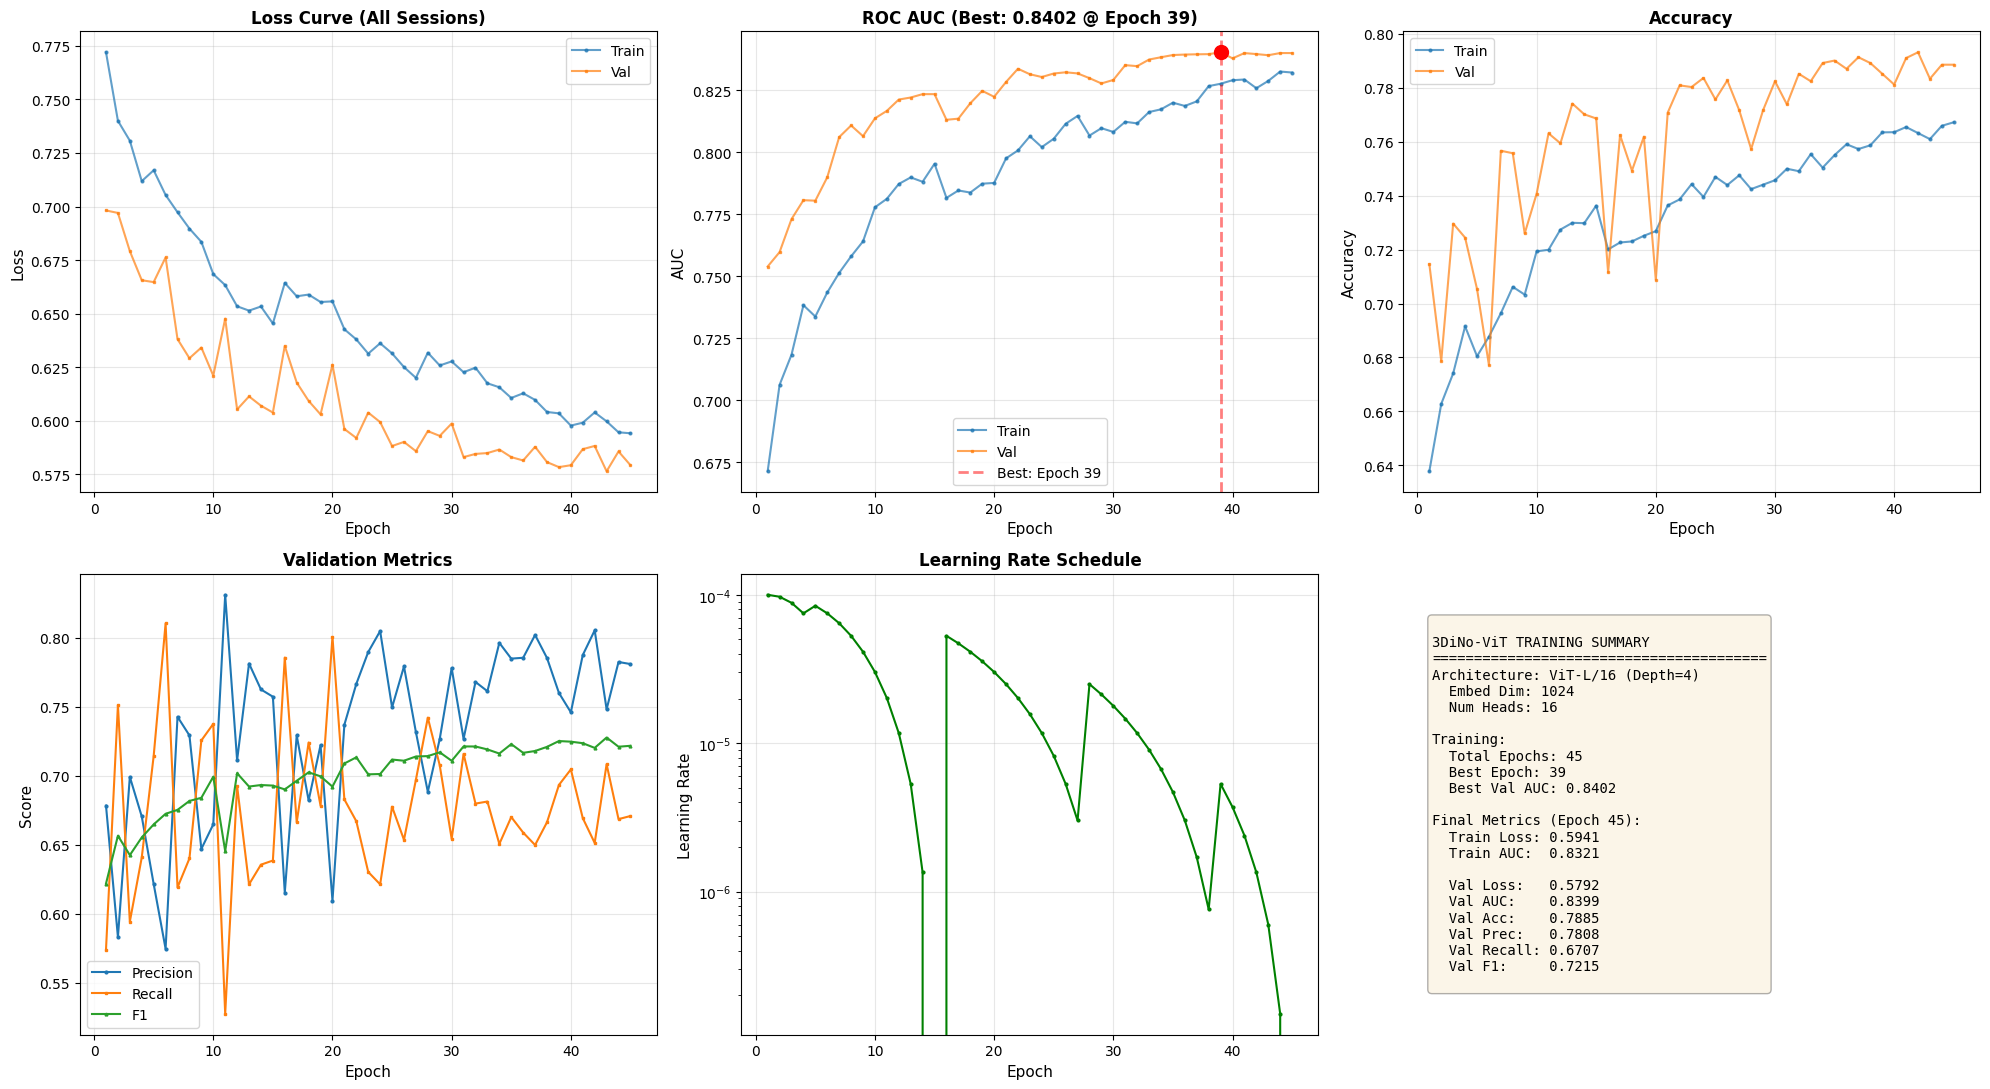

✓ Complete training history plotted



In [13]:
# Cell 11: Plot complete training history
fig, axes = plt.subplots(2, 3, figsize=(20, 11))

epochs = list(range(1, len(history['train_loss']) + 1))

# Loss
axes[0, 0].plot(epochs, history['train_loss'], label='Train', marker='o', markersize=2, alpha=0.7)
axes[0, 0].plot(epochs, history['val_loss'], label='Val', marker='s', markersize=2, alpha=0.7)
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Loss', fontsize=11)
axes[0, 0].set_title('Loss Curve (All Sessions)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# AUC with best marker
axes[0, 1].plot(epochs, history['train_auc'], label='Train', marker='o', markersize=2, alpha=0.7)
axes[0, 1].plot(epochs, history['val_auc'], label='Val', marker='s', markersize=2, alpha=0.7)
best_epoch_idx = np.argmax(history['val_auc'])
best_epoch = epochs[best_epoch_idx]
best_auc = history['val_auc'][best_epoch_idx]
axes[0, 1].axvline(best_epoch, color='red', linestyle='--', alpha=0.5, linewidth=2, label=f'Best: Epoch {best_epoch}')
axes[0, 1].scatter([best_epoch], [best_auc], color='red', s=100, zorder=5)
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('AUC', fontsize=11)
axes[0, 1].set_title(f'ROC AUC (Best: {best_auc:.4f} @ Epoch {best_epoch})', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Accuracy
axes[0, 2].plot(epochs, history['train_acc'], label='Train', marker='o', markersize=2, alpha=0.7)
axes[0, 2].plot(epochs, history['val_acc'], label='Val', marker='s', markersize=2, alpha=0.7)
axes[0, 2].set_xlabel('Epoch', fontsize=11)
axes[0, 2].set_ylabel('Accuracy', fontsize=11)
axes[0, 2].set_title('Accuracy', fontsize=12, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Precision, Recall, F1
axes[1, 0].plot(epochs, history['val_precision'], label='Precision', marker='o', markersize=2)
axes[1, 0].plot(epochs, history['val_recall'], label='Recall', marker='s', markersize=2)
axes[1, 0].plot(epochs, history['val_f1'], label='F1', marker='^', markersize=2)
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('Score', fontsize=11)
axes[1, 0].set_title('Validation Metrics', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Learning rate
axes[1, 1].plot(epochs, history['lr'], marker='o', markersize=2, color='green')
axes[1, 1].set_xlabel('Epoch', fontsize=11)
axes[1, 1].set_ylabel('Learning Rate', fontsize=11)
axes[1, 1].set_title('Learning Rate Schedule', fontsize=12, fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

# Summary
summary_text = f"""
3DiNo-ViT TRAINING SUMMARY
{'='*40}
Architecture: ViT-L/16 (Depth={cfg.DEPTH})
  Embed Dim: {cfg.EMBED_DIM}
  Num Heads: {cfg.NUM_HEADS}

Training:
  Total Epochs: {len(epochs)}
  Best Epoch: {best_epoch}
  Best Val AUC: {best_auc:.4f}

Final Metrics (Epoch {len(epochs)}):
  Train Loss: {history['train_loss'][-1]:.4f}
  Train AUC:  {history['train_auc'][-1]:.4f}
  
  Val Loss:   {history['val_loss'][-1]:.4f}
  Val AUC:    {history['val_auc'][-1]:.4f}
  Val Acc:    {history['val_acc'][-1]:.4f}
  Val Prec:   {history['val_precision'][-1]:.4f}
  Val Recall: {history['val_recall'][-1]:.4f}
  Val F1:     {history['val_f1'][-1]:.4f}
"""
axes[1, 2].text(0.05, 0.5, summary_text, fontsize=10, family='monospace', 
                verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, 'complete_training_history.png'), dpi=200, bbox_inches='tight')
plt.show()

print("✓ Complete training history plotted\n")

In [14]:
# Cell 12: Load best model
def load_best_model():
    """Load the overall best model"""
    
    # Find best model checkpoint (from v4 based on your description)
    best_path = os.path.join(cfg.CHECKPOINT_PATHS['v4'], f'{cfg.MODEL_NAME}_best.pth')
    
    print(f"\n{'='*70}")
    print(f"LOADING BEST MODEL")
    print(f"{'='*70}")
    print(f"Path: {best_path}\n")
    
    model = ThreeDINOClassifier().to(cfg.DEVICE)
    
    checkpoint = torch.load(best_path, map_location=cfg.DEVICE, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"✓ Model loaded successfully")
    if 'val_auc' in checkpoint:
        print(f"  Best Val AUC: {checkpoint['val_auc']:.4f}")
    print(f"{'='*70}\n")
    
    return model, checkpoint

best_model, best_checkpoint = load_best_model()


LOADING BEST MODEL
Path: /kaggle/input/3-dino-vit-v4/pytorch/default/1/3dino_vit_ich_best.pth

✓ Model loaded successfully
  Best Val AUC: 0.8402



In [15]:
def get_predictions(model, dataloader, device, desc="Inference"):
    """Get predictions and labels"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=desc):
            images = batch['image'].to(device, non_blocking=True)
            labels = batch['label'].cpu().numpy()
            
            with torch.cuda.amp.autocast():
                logits = model(images)
                probs = torch.sigmoid(logits).cpu().numpy()
            
            all_preds.extend(probs.flatten())
            all_labels.extend(labels.flatten())
    
    return np.array(all_preds), np.array(all_labels)

print("Getting predictions on all datasets...")
print(f"{'='*70}")

train_preds, train_labels = get_predictions(best_model, train_loader, cfg.DEVICE, "Train")
print(f"✓ Train: {len(train_preds)} predictions")

val_preds, val_labels = get_predictions(best_model, val_loader, cfg.DEVICE, "Val")
print(f"✓ Val: {len(val_preds)} predictions")

test_preds, test_labels = get_predictions(best_model, test_loader, cfg.DEVICE, "Test")
print(f"✓ Test: {len(test_preds)} predictions")

print(f"{'='*70}\n")

Getting predictions on all datasets...


Train:   0%|          | 0/1903 [00:00<?, ?it/s]

✓ Train: 15220 predictions


Val:   0%|          | 0/408 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7913be925940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7913be925940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

✓ Val: 3262 predictions


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7913be925940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7913be925940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Test:   0%|          | 0/408 [00:01<?, ?it/s]

 ^ ^self._shutdown_workers()^  ^^
 ^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^^    ^if w.is_alive():^
^^ ^^^^ ^ ^^ ^^^^^ ^^ ^ ^^^^^^^^^^^^^
^AssertionError^^: ^^can only test a child process^
^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^  ^ 
AssertionError  :  can only test a child process 
    Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7913be925940>^^
^^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():^
 ^^  ^ ^ ^  ^^^^^^^^^^^^^^^^^^^^^^^^^
^^  File "/usr/lib/python3.11/multiprocessing/process.py", line 

✓ Test: 3262 predictions



In [16]:
# Cell 14: Threshold optimization on Train+Val
print(f"{'='*70}")
print(f"THRESHOLD OPTIMIZATION (Train + Val)")
print(f"{'='*70}\n")

# Combine train and val
combined_preds = np.concatenate([train_preds, val_preds])
combined_labels = np.concatenate([train_labels, val_labels])

# Precision-Recall curve
precisions, recalls, thresholds = precision_recall_curve(combined_labels, combined_preds)

# Find optimal thresholds
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-10)

# 1. Best F1
best_f1_idx = np.argmax(f1_scores)
optimal_threshold_f1 = thresholds[best_f1_idx]
optimal_f1 = f1_scores[best_f1_idx]

# 2. Target Recall = 0.75
target_recall = 0.75
recall_idx = np.argmin(np.abs(recalls[:-1] - target_recall))
threshold_recall_75 = thresholds[recall_idx]

# 3. Target Precision = 0.80
target_precision = 0.80
prec_idx = np.argmin(np.abs(precisions[:-1] - target_precision))
threshold_prec_80 = thresholds[prec_idx]

THRESHOLD OPTIMIZATION (Train + Val)



In [17]:
def eval_threshold(preds, labels, threshold):
    binary = (preds > threshold).astype(int)
    return {
        'precision': precision_score(labels, binary, zero_division=0),
        'recall': recall_score(labels, binary, zero_division=0),
        'f1': f1_score(labels, binary, zero_division=0),
        'acc': accuracy_score(labels, binary)
    }


Threshold Analysis (Train + Val):

1. Default (0.5):
   Precision: 0.7994
   Recall: 0.7544
   F1: 0.7763
   Acc: 0.8224

2. Optimal F1 (0.4827):
   Precision: 0.7910
   Recall: 0.7675
   F1: 0.7791
   Acc: 0.8222

3. Target Recall=0.75 (0.5068):
   Precision: 0.8032
   Recall: 0.7489
   F1: 0.7751
   Acc: 0.8225

4. Target Precision=0.80 (0.5024):
   Precision: 0.8007
   Recall: 0.7521
   F1: 0.7756
   Acc: 0.8223


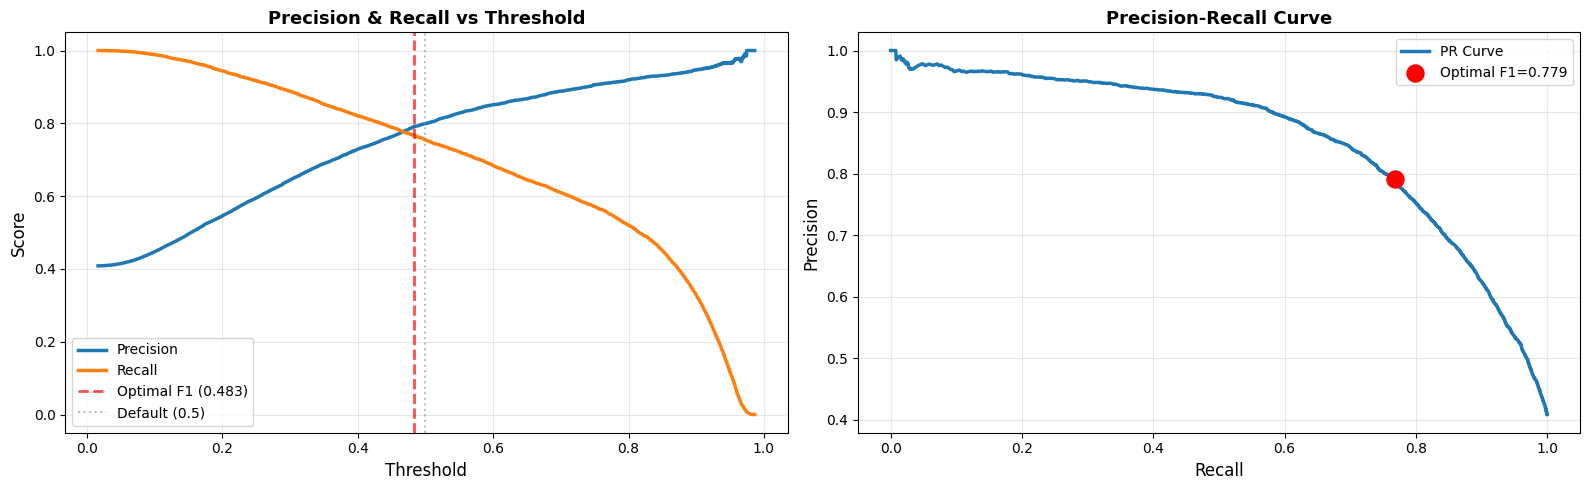

In [18]:
print("Threshold Analysis (Train + Val):\n")

print("1. Default (0.5):")
metrics_05 = eval_threshold(combined_preds, combined_labels, 0.5)
for k, v in metrics_05.items():
    print(f"   {k.capitalize()}: {v:.4f}")

print(f"\n2. Optimal F1 ({optimal_threshold_f1:.4f}):")
metrics_opt = eval_threshold(combined_preds, combined_labels, optimal_threshold_f1)
for k, v in metrics_opt.items():
    print(f"   {k.capitalize()}: {v:.4f}")

print(f"\n3. Target Recall=0.75 ({threshold_recall_75:.4f}):")
metrics_rec = eval_threshold(combined_preds, combined_labels, threshold_recall_75)
for k, v in metrics_rec.items():
    print(f"   {k.capitalize()}: {v:.4f}")

print(f"\n4. Target Precision=0.80 ({threshold_prec_80:.4f}):")
metrics_prec = eval_threshold(combined_preds, combined_labels, threshold_prec_80)
for k, v in metrics_prec.items():
    print(f"   {k.capitalize()}: {v:.4f}")

# Plot threshold analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Precision/Recall vs Threshold
axes[0].plot(thresholds, precisions[:-1], label='Precision', linewidth=2.5)
axes[0].plot(thresholds, recalls[:-1], label='Recall', linewidth=2.5)
axes[0].axvline(optimal_threshold_f1, color='red', linestyle='--', alpha=0.7, linewidth=2, label=f'Optimal F1 ({optimal_threshold_f1:.3f})')
axes[0].axvline(0.5, color='gray', linestyle=':', alpha=0.5, label='Default (0.5)')
axes[0].set_xlabel('Threshold', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Precision & Recall vs Threshold', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# PR Curve
axes[1].plot(recalls, precisions, linewidth=2.5, label='PR Curve')
axes[1].scatter([metrics_opt['recall']], [metrics_opt['precision']], 
                c='red', s=150, zorder=5, label=f'Optimal F1={optimal_f1:.3f}')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, 'threshold_optimization.png'), dpi=200, bbox_inches='tight')
plt.show()

print(f"\n{'='*70}\n")

In [19]:
# Cell 15: Test set evaluation with multiple thresholds
print(f"{'='*70}")
print(f"TEST SET EVALUATION")
print(f"{'='*70}\n")

test_auc = roc_auc_score(test_labels, test_preds)
print(f"Test AUC: {test_auc:.4f}\n")

thresholds_to_test = [
    ('Default (0.5)', 0.5),
    ('Optimal F1', optimal_threshold_f1),
    ('Recall ≈ 0.75', threshold_recall_75),
    ('Precision ≈ 0.80', threshold_prec_80),
]

test_results = []

for name, thresh in thresholds_to_test:
    binary_preds = (test_preds > thresh).astype(int)
    
    result = {
        'threshold_name': name,
        'threshold': thresh,
        'auc': test_auc,
        'accuracy': accuracy_score(test_labels, binary_preds),
        'precision': precision_score(test_labels, binary_preds, zero_division=0),
        'recall': recall_score(test_labels, binary_preds, zero_division=0),
        'f1': f1_score(test_labels, binary_preds, zero_division=0)
    }
    test_results.append(result)
    
    print(f"{name} (threshold={thresh:.4f}):")
    print(f"  AUC:       {result['auc']:.4f}")
    print(f"  Accuracy:  {result['accuracy']:.4f}")
    print(f"  Precision: {result['precision']:.4f}")
    print(f"  Recall:    {result['recall']:.4f}")
    print(f"  F1:        {result['f1']:.4f}")
    print()

# Create results DataFrame
results_df = pd.DataFrame(test_results)

print(f"{'='*70}")
print("TEST SET RESULTS SUMMARY")
print(f"{'='*70}")
print(results_df.to_string(index=False))
print(f"{'='*70}\n")

# Save results
results_df.to_csv(os.path.join(cfg.OUTPUT_DIR, 'test_results_3dino.csv'), index=False)
print("✓ Results saved to test_results_3dino.csv\n")

TEST SET EVALUATION

Test AUC: 0.8509

Default (0.5) (threshold=0.5000):
  AUC:       0.8509
  Accuracy:  0.7915
  Precision: 0.7563
  Recall:    0.7222
  F1:        0.7389

Optimal F1 (threshold=0.4827):
  AUC:       0.8509
  Accuracy:  0.7900
  Precision: 0.7453
  Recall:    0.7380
  F1:        0.7416

Recall ≈ 0.75 (threshold=0.5068):
  AUC:       0.8509
  Accuracy:  0.7922
  Precision: 0.7591
  Recall:    0.7192
  F1:        0.7386

Precision ≈ 0.80 (threshold=0.5024):
  AUC:       0.8509
  Accuracy:  0.7922
  Precision: 0.7579
  Recall:    0.7215
  F1:        0.7392

TEST SET RESULTS SUMMARY
  threshold_name  threshold      auc  accuracy  precision   recall       f1
   Default (0.5)   0.500000 0.850884  0.791539   0.756289 0.722222 0.738863
      Optimal F1   0.482666 0.850884  0.790006   0.745262 0.737988 0.741607
   Recall ≈ 0.75   0.506836 0.850884  0.792152   0.759113 0.719219 0.738628
Precision ≈ 0.80   0.502441 0.850884  0.792152   0.757886 0.721471 0.739231

✓ Results saved

DETAILED TEST SET ANALYSIS (Optimal F1 Threshold)

Confusion Matrix:
  True Negatives:  1594
  False Positives: 336
  False Negatives: 349
  True Positives:  983

Additional Metrics:
  Sensitivity (TPR): 0.7380
  Specificity (TNR): 0.8259
  PPV (Precision):   0.7453
  NPV:               0.8204



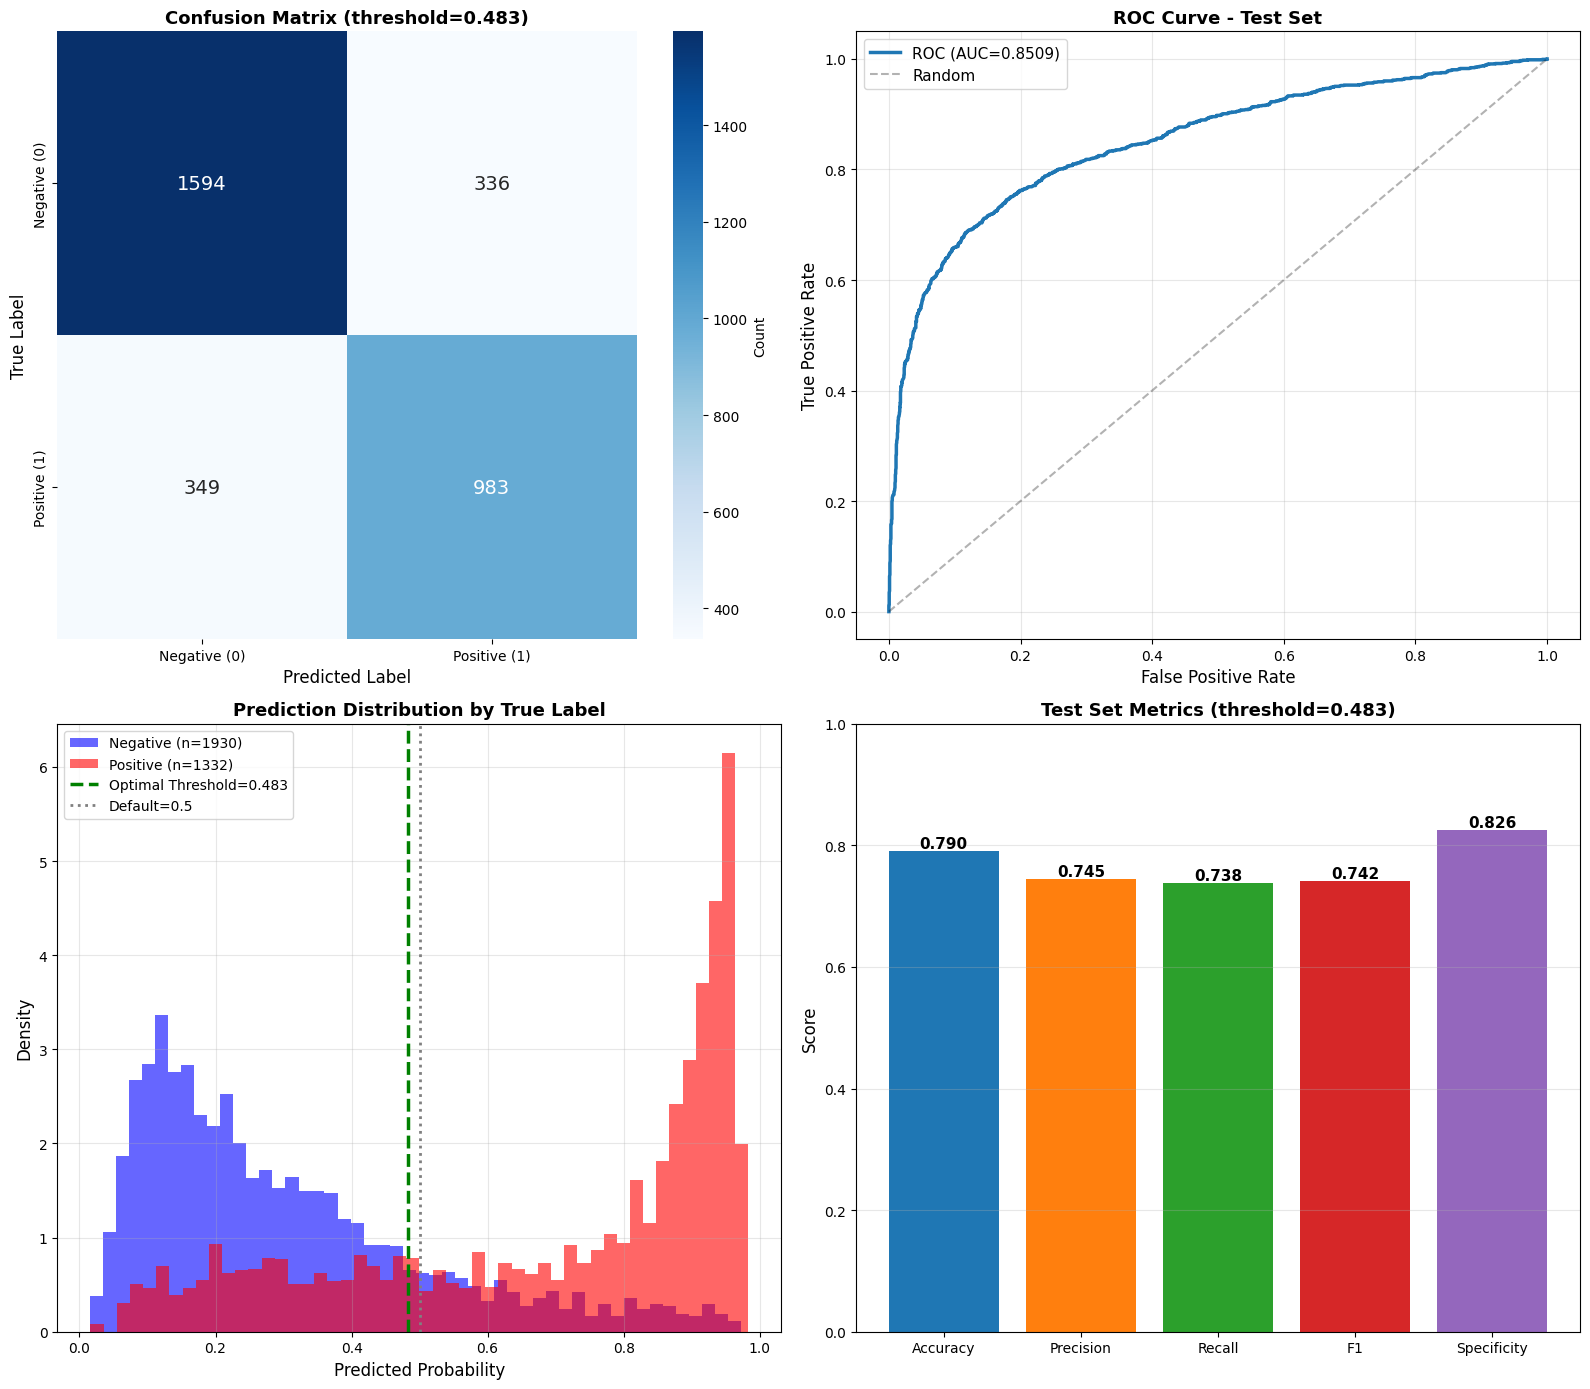


✓ Test set analysis plots saved



In [20]:
# Cell 16: Detailed test set analysis
print(f"{'='*70}")
print(f"DETAILED TEST SET ANALYSIS (Optimal F1 Threshold)")
print(f"{'='*70}\n")

optimal_test_preds = (test_preds > optimal_threshold_f1).astype(int)

# Confusion matrix
cm = confusion_matrix(test_labels, optimal_test_preds)
tn, fp, fn, tp = cm.ravel()

print(f"Confusion Matrix:")
print(f"  True Negatives:  {tn}")
print(f"  False Positives: {fp}")
print(f"  False Negatives: {fn}")
print(f"  True Positives:  {tp}")
print()

# Additional metrics
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0

print(f"Additional Metrics:")
print(f"  Sensitivity (TPR): {sensitivity:.4f}")
print(f"  Specificity (TNR): {specificity:.4f}")
print(f"  PPV (Precision):   {ppv:.4f}")
print(f"  NPV:               {npv:.4f}")
print()

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0], 
            cbar_kws={'label': 'Count'}, annot_kws={'size': 14})
axes[0, 0].set_xlabel('Predicted Label', fontsize=12)
axes[0, 0].set_ylabel('True Label', fontsize=12)
axes[0, 0].set_title(f'Confusion Matrix (threshold={optimal_threshold_f1:.3f})', 
                     fontsize=13, fontweight='bold')
axes[0, 0].set_xticklabels(['Negative (0)', 'Positive (1)'])
axes[0, 0].set_yticklabels(['Negative (0)', 'Positive (1)'])

# 2. ROC Curve
fpr, tpr, _ = roc_curve(test_labels, test_preds)
axes[0, 1].plot(fpr, tpr, linewidth=2.5, label=f'ROC (AUC={test_auc:.4f})')
axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')
axes[0, 1].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 1].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 1].set_title('ROC Curve - Test Set', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 3. Prediction Distribution
axes[1, 0].hist(test_preds[test_labels == 0], bins=50, alpha=0.6, 
               label=f'Negative (n={sum(test_labels==0)})', density=True, color='blue')
axes[1, 0].hist(test_preds[test_labels == 1], bins=50, alpha=0.6, 
               label=f'Positive (n={sum(test_labels==1)})', density=True, color='red')
axes[1, 0].axvline(optimal_threshold_f1, color='green', linestyle='--', linewidth=2.5, 
                  label=f'Optimal Threshold={optimal_threshold_f1:.3f}')
axes[1, 0].axvline(0.5, color='gray', linestyle=':', linewidth=2, label='Default=0.5')
axes[1, 0].set_xlabel('Predicted Probability', fontsize=12)
axes[1, 0].set_ylabel('Density', fontsize=12)
axes[1, 0].set_title('Prediction Distribution by True Label', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# 4. Metrics Bar Chart
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'Specificity']
metrics_values = [
    results_df[results_df['threshold_name']=='Optimal F1']['accuracy'].values[0],
    results_df[results_df['threshold_name']=='Optimal F1']['precision'].values[0],
    results_df[results_df['threshold_name']=='Optimal F1']['recall'].values[0],
    results_df[results_df['threshold_name']=='Optimal F1']['f1'].values[0],
    specificity
]

bars = axes[1, 1].bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
axes[1, 1].set_ylim(0, 1)
axes[1, 1].set_ylabel('Score', fontsize=12)
axes[1, 1].set_title(f'Test Set Metrics (threshold={optimal_threshold_f1:.3f})', 
                     fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, metrics_values):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, 'test_set_detailed_analysis.png'), dpi=200, bbox_inches='tight')
plt.show()

print(f"\n✓ Test set analysis plots saved\n")

COMPARISON ACROSS ALL DATASETS (Optimal F1 Threshold)

Dataset  Samples Positive %      AUC  Accuracy  Precision   Recall       F1
  Train    15220      40.8% 0.894158  0.830355   0.799078 0.781084 0.789979
    Val     3262      40.9% 0.840225  0.784181   0.751801 0.704426 0.727343
   Test     3262      40.8% 0.850884  0.790006   0.745262 0.737988 0.741607




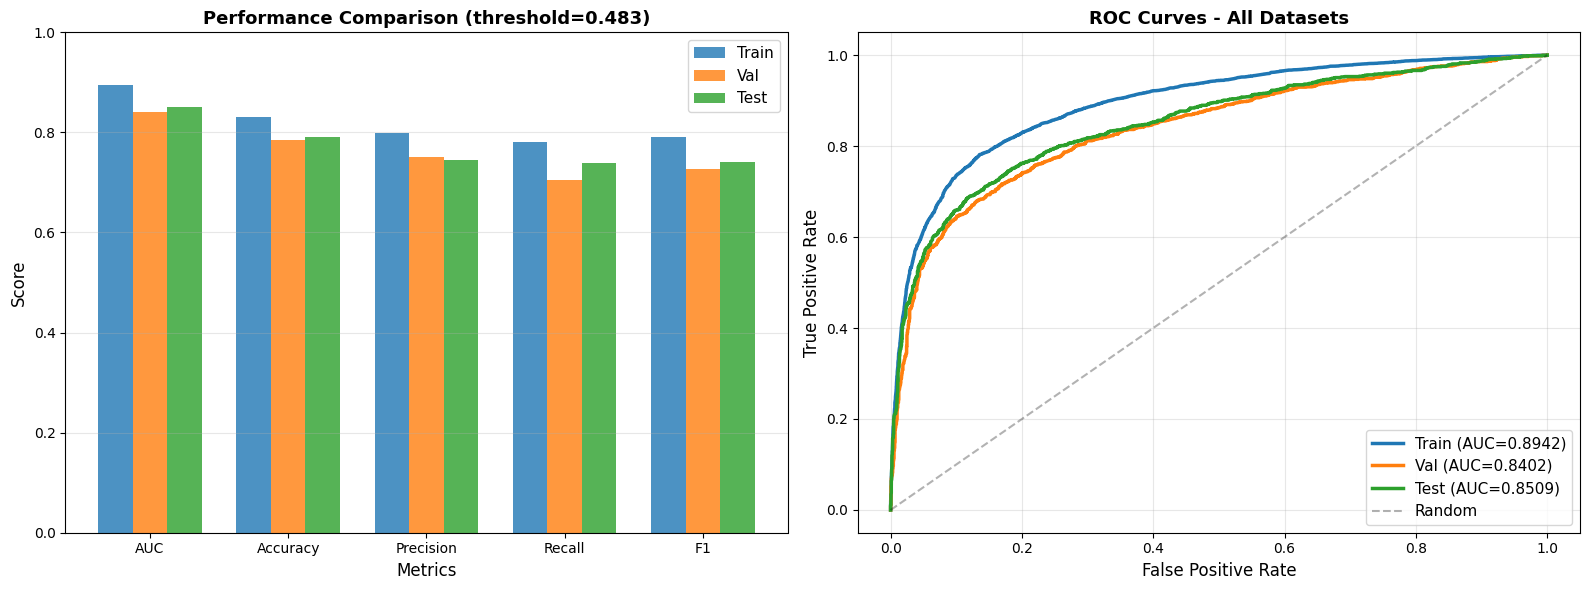

✓ Comparison plots saved



In [21]:
# Cell 17: Comparison across all sets
print(f"{'='*70}")
print(f"COMPARISON ACROSS ALL DATASETS (Optimal F1 Threshold)")
print(f"{'='*70}\n")

# Evaluate on all sets with optimal threshold
sets_comparison = []

for set_name, preds, labels in [
    ('Train', train_preds, train_labels),
    ('Val', val_preds, val_labels),
    ('Test', test_preds, test_labels)
]:
    binary = (preds > optimal_threshold_f1).astype(int)
    
    sets_comparison.append({
        'Dataset': set_name,
        'Samples': len(labels),
        'Positive %': f"{labels.mean()*100:.1f}%",
        'AUC': roc_auc_score(labels, preds),
        'Accuracy': accuracy_score(labels, binary),
        'Precision': precision_score(labels, binary, zero_division=0),
        'Recall': recall_score(labels, binary, zero_division=0),
        'F1': f1_score(labels, binary, zero_division=0)
    })

comparison_df = pd.DataFrame(sets_comparison)

print(comparison_df.to_string(index=False))
print(f"\n{'='*70}\n")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Metrics comparison
metrics_to_plot = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1']
x = np.arange(len(metrics_to_plot))
width = 0.25

for i, set_name in enumerate(['Train', 'Val', 'Test']):
    values = [comparison_df[comparison_df['Dataset']==set_name][m].values[0] for m in metrics_to_plot]
    axes[0].bar(x + i*width, values, width, label=set_name, alpha=0.8)

axes[0].set_xlabel('Metrics', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title(f'Performance Comparison (threshold={optimal_threshold_f1:.3f})', 
                  fontsize=13, fontweight='bold')
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(metrics_to_plot)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim(0, 1)

# ROC curves comparison
for set_name, preds, labels in [
    ('Train', train_preds, train_labels),
    ('Val', val_preds, val_labels),
    ('Test', test_preds, test_labels)
]:
    fpr, tpr, _ = roc_curve(labels, preds)
    auc = roc_auc_score(labels, preds)
    axes[1].plot(fpr, tpr, linewidth=2.5, label=f'{set_name} (AUC={auc:.4f})')

axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curves - All Datasets', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, 'datasets_comparison.png'), dpi=200, bbox_inches='tight')
plt.show()

print("✓ Comparison plots saved\n")

In [22]:
# Cell 18: Final summary report
print(f"\n{'='*70}")
print(f"FINAL EVALUATION SUMMARY - 3DiNo ViT")
print(f"{'='*70}\n")

summary_report = f"""
MODEL ARCHITECTURE:
  Name: 3DiNo ViT Classifier
  Backbone: ViT-Large/16 (Depth={cfg.DEPTH}, Embed={cfg.EMBED_DIM})
  Input Size: {cfg.INPUT_SIZE}
  Parameters: ~{sum(p.numel() for p in best_model.parameters())/1e6:.1f}M

TRAINING:
  Total Epochs: {len(history['train_loss'])}
  Best Epoch: {best_epoch}
  Best Val AUC: {best_auc:.4f}
  Training Strategy: {cfg.CHECKPOINT_PATHS}

THRESHOLD OPTIMIZATION (Train + Val):
  Optimal Threshold: {optimal_threshold_f1:.4f}
  Method: Maximize F1 Score

TEST SET PERFORMANCE:
  AUC: {test_auc:.4f}
  
  With Optimal Threshold ({optimal_threshold_f1:.4f}):
    Accuracy:  {results_df[results_df['threshold_name']=='Optimal F1']['accuracy'].values[0]:.4f}
    Precision: {results_df[results_df['threshold_name']=='Optimal F1']['precision'].values[0]:.4f}
    Recall:    {results_df[results_df['threshold_name']=='Optimal F1']['recall'].values[0]:.4f}
    F1 Score:  {results_df[results_df['threshold_name']=='Optimal F1']['f1'].values[0]:.4f}
    
  Confusion Matrix:
    True Negatives:  {tn}
    False Positives: {fp}
    False Negatives: {fn}
    True Positives:  {tp}
    
  Clinical Metrics:
    Sensitivity: {sensitivity:.4f}
    Specificity: {specificity:.4f}
    PPV:         {ppv:.4f}
    NPV:         {npv:.4f}

GENERALIZATION:
  Train AUC: {roc_auc_score(train_labels, train_preds):.4f}
  Val AUC:   {roc_auc_score(val_labels, val_preds):.4f}
  Test AUC:  {test_auc:.4f}
  Gap (Val-Test): {roc_auc_score(val_labels, val_preds) - test_auc:.4f}
"""

print(summary_report)
print(f"{'='*70}\n")

# Save summary to file
with open(os.path.join(cfg.OUTPUT_DIR, 'evaluation_summary.txt'), 'w') as f:
    f.write(summary_report)

print("✓ Summary report saved to evaluation_summary.txt")

# Save all predictions for further analysis
np.savez(
    os.path.join(cfg.OUTPUT_DIR, 'all_predictions.npz'),
    train_preds=train_preds, train_labels=train_labels,
    val_preds=val_preds, val_labels=val_labels,
    test_preds=test_preds, test_labels=test_labels,
    optimal_threshold=optimal_threshold_f1
)
print("✓ All predictions saved to all_predictions.npz")

print(f"\n{'='*70}")
print(f"EVALUATION COMPLETED!")
print(f"{'='*70}")
print(f"\nAll outputs saved to: {cfg.OUTPUT_DIR}")
print(f"\nGenerated files:")
print(f"  1. complete_training_history.png")
print(f"  2. threshold_optimization.png")
print(f"  3. test_set_detailed_analysis.png")
print(f"  4. datasets_comparison.png")
print(f"  5. test_results_3dino.csv")
print(f"  6. evaluation_summary.txt")
print(f"  7. all_predictions.npz")
print(f"\n{'='*70}\n")


FINAL EVALUATION SUMMARY - 3DiNo ViT


MODEL ARCHITECTURE:
  Name: 3DiNo ViT Classifier
  Backbone: ViT-Large/16 (Depth=4, Embed=1024)
  Input Size: (96, 96, 96)
  Parameters: ~55.9M

TRAINING:
  Total Epochs: 45
  Best Epoch: 39
  Best Val AUC: 0.8402
  Training Strategy: {'v2': '/kaggle/input/3dino-vit-v2/pytorch/default/1', 'v3_session1': '/kaggle/input/3dino-vit-v3/pytorch/default/1', 'v3_session2': '/kaggle/input/3dino-vit-v3/pytorch/default/2', 'v3_session3': '/kaggle/input/3dino-vit-v3/pytorch/default/3', 'v4': '/kaggle/input/3-dino-vit-v4/pytorch/default/1'}

THRESHOLD OPTIMIZATION (Train + Val):
  Optimal Threshold: 0.4827
  Method: Maximize F1 Score

TEST SET PERFORMANCE:
  AUC: 0.8509
  
  With Optimal Threshold (0.4827):
    Accuracy:  0.7900
    Precision: 0.7453
    Recall:    0.7380
    F1 Score:  0.7416
    
  Confusion Matrix:
    True Negatives:  1594
    False Positives: 336
    False Negatives: 349
    True Positives:  983
    
  Clinical Metrics:
    Sensitivity: 